# Feature Engineer Lending Club Data
## Data Prep Step 2 of 2

- Drop unused columns
- Fix Data types
- Engineering Features

In [1]:
from __future__ import print_function 
from __future__ import division

# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
import itertools
import datetime

import warnings
warnings.filterwarnings('ignore')

SEED = 42

# Flag to use external features or not
EXTERNALFEATURES = False

In [2]:
# Load in pre-processed data set with the 
df = pd.read_csv('LendingClub2017_2018BasicPrep.csv.gz',  compression='gzip')
df.sample(3)

,loan_amnt,term,int_rate,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
90834,8325.0,36 months,18.99,D,FoH,1 year,RENT,28100.0,Source Verified,2016-12-01,...,0.0,0.0,0.0,25.0,0.0,0.0,22579.0,8597.0,5900.0,16679.0
174214,10000.0,36 months,6.99,A,Pharmacy Manager,1 year,MORTGAGE,132000.0,Not Verified,2016-01-01,...,0.0,0.0,3.0,36.4,0.0,0.0,463535.0,98716.0,63200.0,113935.0
45453,20000.0,36 months,10.99,B,manager,6 years,RENT,70000.0,Source Verified,2016-07-01,...,0.0,0.0,0.0,0.0,0.0,0.0,49695.0,40415.0,4900.0,20795.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178792 entries, 0 to 178791
Data columns (total 81 columns):
loan_amnt                         178792 non-null float64
term                              178792 non-null object
int_rate                          178792 non-null float64
grade                             178792 non-null object
emp_title                         167422 non-null object
emp_length                        167531 non-null object
home_ownership                    178792 non-null object
annual_inc                        178792 non-null float64
verification_status               178792 non-null object
issue_d                           178792 non-null object
loan_status                       178792 non-null object
purpose                           178792 non-null object
zip_code                          178792 non-null object
addr_state                        178792 non-null object
dti                               178792 non-null float64
delinq_2yrs                   

# Helper Functions

In [4]:
def reviewObject(df, name, size=None, title=None):
    (df[name].value_counts().sort_index()).plot.bar(rot=45, figsize=size, title=title)
    plt.show()
    display(df[name].value_counts().sort_index())

def plotCorr(df, lst, size=None):
    correlations = df[lst].corr() * 100
    mask = np.zeros_like(correlations, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure() #figsize=(10,8)
    # Plot heatmap of correlations
    #print (correlations)
    with sns.plotting_context("notebook", font_scale=2.0):
        fig, ax = plt.subplots(figsize=size) 
        sns.heatmap(correlations, annot=True, cbar=True, cmap='Greens', mask=mask, fmt='.0f') 
    plt.show()

# Target Training Variable: loan_status

We will train on loan status. For this, we only want Charged off/Defaulted and paid and we will drop anything else. 

We will rebucket 'Charged Off','Default' to the value of 1
'Fully Paid','Completed' to the value of 0


In [5]:
display(df['loan_status'].value_counts())

Fully Paid     140379
Charged Off     38413
Name: loan_status, dtype: int64

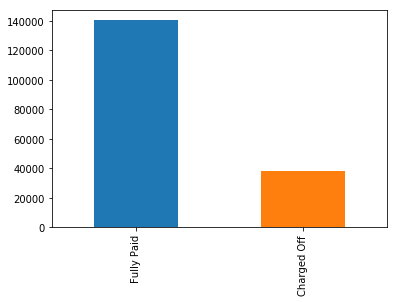

In [6]:
plt.figure()
df['loan_status'].value_counts(dropna=False).plot.bar()
plt.show()

In [7]:
#project.addManualRuleForDefault(ed.CLEANDATA_DROP_NA_FOR_COLUMN, 'loan_status')
df['loan_status'].replace(['Charged Off','Default'], 1, inplace=True)
df['loan_status'].replace(['Fully Paid','Completed'], 0, inplace=True)

#project.addManualRuleForDefault(ed.CLEANDATA_CONVERT_DATATYPE, 'loan_status','int64')
#project.addManualRuleForDefault(ed.CLEANDATA_CONVERT_DATATYPE, 'issue_d','datetime64')
df['loan_status'] = df['loan_status'].astype('int64')


0    140379
1     38413
Name: loan_status, dtype: int64

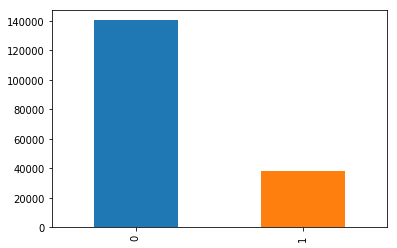

In [8]:
df['loan_status'].value_counts(dropna=False).plot.bar()
df['loan_status'].value_counts()

# Objects


## Term

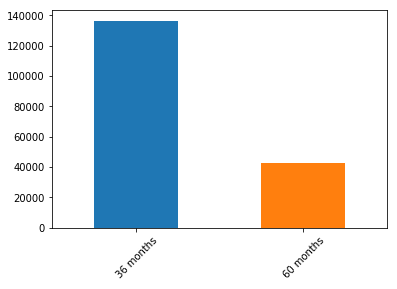

 36 months    136373
 60 months     42419
Name: term, dtype: int64

In [9]:
reviewObject(df,'term')

## Grade

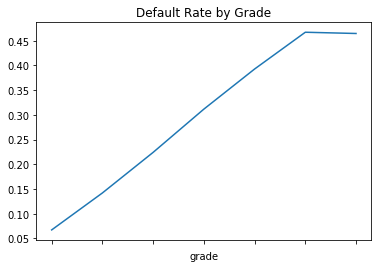

In [10]:
# Default Rate by Grade
df.groupby('grade')['loan_status'].mean().plot.line(title='Default Rate by Grade')

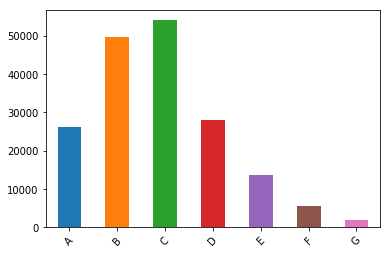

A    26248
B    49584
C    54018
D    27888
E    13626
F     5571
G     1857
Name: grade, dtype: int64

In [11]:

reviewObject(df,'grade')
#df['grade'].replace(['A'], 1, inplace=True)
#df['grade'].replace(['B'], 2, inplace=True)
#df['grade'].replace(['C'], 3, inplace=True)
#df['grade'].replace(['D'], 4, inplace=True)
#df['grade'].replace(['E'], 5, inplace=True)
#df['grade'].replace(['F'], 6, inplace=True)
#df['grade'].replace(['G'], 7, inplace=True)
#df['grade'].dropna(inplace=True)
#df['grade'] = df['grade'].astype('int64')

#plotCorr(df,['grade','int_rate'], size=None)

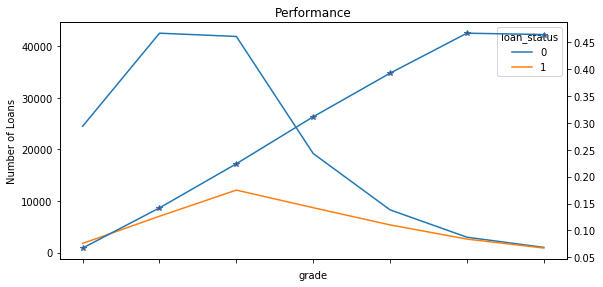

In [12]:
df2 = df.groupby(['loan_status', 'grade'])['grade'].count().unstack('loan_status').fillna(0)


#plt.figure()
df2['predict'] = df2[1] / (df2[0] + df2[1])


grade = [0,1,2,3,4,5,6,7]
defaults = df2[[0,1]]
predict = df2['predict']


fig = plt.figure(figsize=(20,20))
ax = plt.subplot2grid((4,2), (0,1))

defaults.plot( kind='line', ax=ax)


ax2 = ax.twinx()
predict.plot(ax=ax2, kind='line',  secondary_y=True, marker='*', markerfacecolor='red')


ax.set_title('Performance')
ax2.set_ylabel('Default Rate')
ax.set_ylabel('Number of Loans')
#ax.set_xticklabels(('A', 'B', 'C', 'D', 'E', 'F', 'G'))

fig.show()



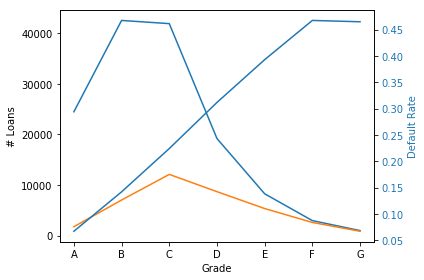

In [13]:
# Create some mock data
grade = df2.index
defaults = df2[[0,1]]
predict = df2['predict']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Grade')
ax1.set_ylabel('# Loans')
ax1.plot(grade, defaults)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Default Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(grade, predict, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## home_ownership

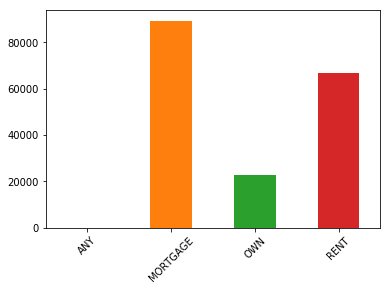

ANY            93
MORTGAGE    89376
OWN         22698
RENT        66625
Name: home_ownership, dtype: int64

In [14]:
reviewObject(df,'home_ownership')

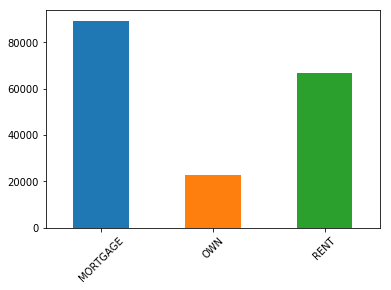

MORTGAGE    89376
OWN         22698
RENT        66625
Name: home_ownership, dtype: int64

In [15]:
# Replace ANY with rent
df.drop(df[df['home_ownership'] == 'ANY'].index, inplace=True)
reviewObject(df,'home_ownership')

## Verification Status

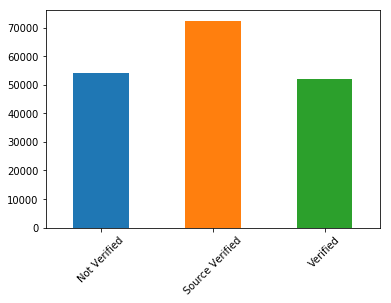

Not Verified       54237
Source Verified    72445
Verified           52017
Name: verification_status, dtype: int64

In [16]:
reviewObject(df,'verification_status')

## Purpose

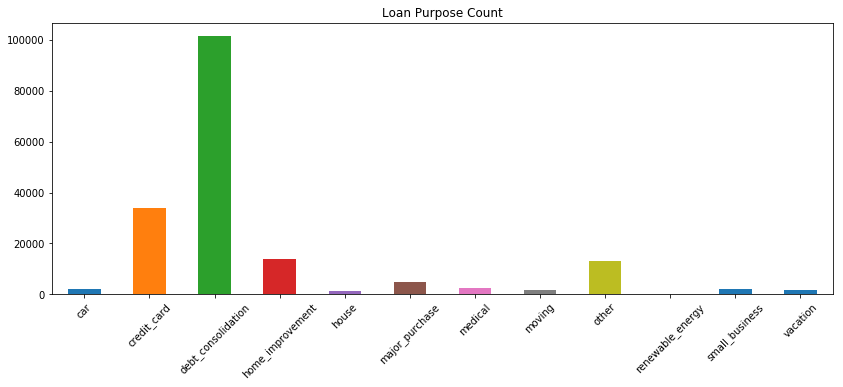

car                     2148
credit_card            33920
debt_consolidation    101695
home_improvement       14031
house                   1312
major_purchase          4752
medical                 2578
moving                  1600
other                  12987
renewable_energy         141
small_business          1948
vacation                1587
Name: purpose, dtype: int64

In [17]:
reviewObject(df,'purpose', size=(14,5), title='Loan Purpose Count')
df['purpose'].fillna('Missing',inplace = True)

## Zip Code

In [18]:
df['zip_code'].describe()

count     178699
unique       897
top        945xx
freq        2143
Name: zip_code, dtype: object

## Addr_state

In [19]:
df['addr_state'].describe()

count     178699
unique        50
top           CA
freq       26277
Name: addr_state, dtype: object

## emp_length

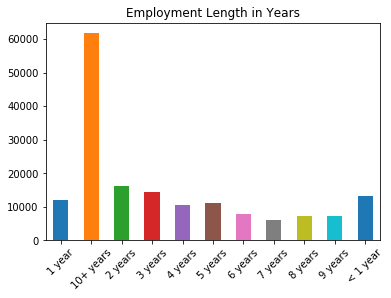

1 year       12121
10+ years    61738
2 years      16288
3 years      14312
4 years      10538
5 years      10995
6 years       7673
7 years       6129
8 years       7295
9 years       7113
< 1 year     13240
Name: emp_length, dtype: int64

In [20]:
reviewObject(df,'emp_length',title='Employment Length in Years')

In [21]:
df['emp_length'].replace(['< 1 year'], 6, inplace=True)
df['emp_length'].replace(['1 year'], 12, inplace=True)
df['emp_length'].replace(['2 years'], 24, inplace=True)
df['emp_length'].replace(['3 years'], 36, inplace=True)
df['emp_length'].replace(['4 years'], 48, inplace=True)
df['emp_length'].replace(['5 years'], 60, inplace=True)
df['emp_length'].replace(['6 years'], 72, inplace=True)
df['emp_length'].replace(['7 years'], 84, inplace=True)
df['emp_length'].replace(['8 years'], 96, inplace=True)
df['emp_length'].replace(['9 years'], 108, inplace=True)
df['emp_length'].replace(['10+ years'], 120, inplace=True)

df['emp_length'].fillna(0, inplace = True)
df['emp_length'] = df['emp_length'].astype('int64')

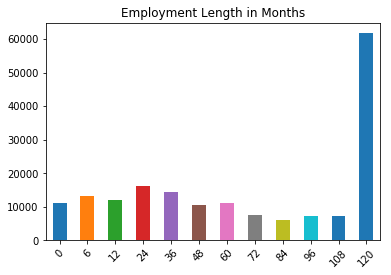

0      11257
6      13240
12     12121
24     16288
36     14312
48     10538
60     10995
72      7673
84      6129
96      7295
108     7113
120    61738
Name: emp_length, dtype: int64

In [22]:
reviewObject(df,'emp_length',title='Employment Length in Months')

## emp_title

In [23]:
#reviewObject(df,'emp_title')
#display(df['emp_title'].value_counts().sort_index())
df['emp_title'].describe()

count      167339
unique      58884
top       Manager
freq         3238
Name: emp_title, dtype: object

# Highly Correlated Data

## fico range low and high

<Figure size 432x288 with 0 Axes>

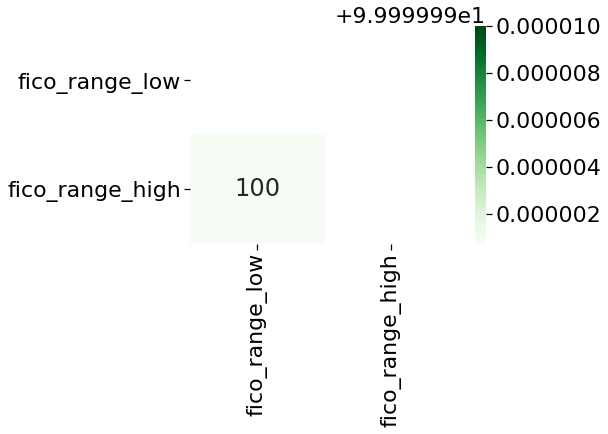

In [24]:
#df[['grade','term']].corr()
plotCorr(df,['fico_range_low','fico_range_high'], size=None)

In [25]:
df['AvgCreditScore'] = ( df['fico_range_low'] + df['fico_range_high'] ) / 2.0
df['AvgCreditScore'] = df['AvgCreditScore'].astype('int64')

# Missing Values

### Fill in missing data with zeros

This is making an assumption that the missing data means that there are no values to report vs unreported values.

In [26]:
missing = ['inq_last_6mths','mths_since_last_delinq','mths_since_last_record','revol_util',
           'mths_since_last_major_derog','open_acc_6m','open_act_il','open_il_12m','open_il_24m',
           'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
           'inq_fi','inq_last_12m','avg_cur_bal','bc_open_to_buy','bc_util','mo_sin_old_il_acct',
           'mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_inq',
           'mths_since_recent_revol_delinq','num_accts_ever_120_pd','num_tl_120dpd_2m','percent_bc_gt_75']

for x in missing:
    df[x].fillna(0, inplace = True)


# Outliers

- For annual_inc 15 outliers above 4200000.0
- For tot_coll_amt 2 outliers above 173380.0
- For acc_open_past_24mths 1 outliers above 56.0
- For mo_sin_rcnt_tl 2 outliers above 289.0
- For mort_acc 2 outliers above 37.0
- For num_actv_bc_tl 4 outliers above 29.0
- For num_sats 2 outliers above 80.0
- For num_tl_op_past_12m 4 outliers above 28.0
- For tot_hi_cred_lim 3 outliers above 9999999.0
- For total_bal_ex_mort 3 outliers above 1234429.0
- For total_bc_limit 1 outliers above 1105500.0
- For total_il_high_credit_limit 5 outliers above 1120706.0


In [27]:
outliers =[('annual_inc',4200000.0),
           ('tot_coll_amt',173380.0),
           ('acc_open_past_24mths',56.0),
           ('mo_sin_rcnt_tl',289.0),
           ('mort_acc',37.0),
           ('num_actv_bc_tl',29.0),
           ('num_sats',80.0),
           ('num_tl_op_past_12m',28.0),
           ('tot_hi_cred_lim',9999999.0),
           ('total_bal_ex_mort',1234429.0),
           ('total_bc_limit',1105500.0),
           ('total_il_high_credit_limit',1120706.0)]

for col,val in outliers:
    df.drop(df[df[col] >= val].index, inplace=True)

# Date Data

In [28]:
df['issue_d'] = df['issue_d'].astype('datetime64')
df['earliest_cr_line'] = df['earliest_cr_line'].astype('datetime64')

df['CreditHistoryMonths'] = ((abs(df['earliest_cr_line']- df['issue_d']))/np.timedelta64(1, 'M'))
df['CreditHistoryMonths'] = df['CreditHistoryMonths'].astype(int)

0         275
1         208
2          51
3         130
4         109
5         331
6         109
7         248
8         216
9         184
10        164
11        239
12        219
13         47
14        172
15        462
16        203
17        159
18        139
19        119
20        236
21        155
22        178
23        157
24        450
25        119
26        324
27        210
28        178
29        220
         ... 
178762     68
178763     46
178764    123
178765    167
178766    265
178767     56
178768    291
178769    448
178770    175
178771     46
178772    229
178773    260
178774    178
178775    127
178776    588
178777    537
178778    440
178779    178
178780    116
178781    275
178782    151
178783    133
178784    123
178785    205
178786    194
178787    203
178788    133
178789    275
178790    196
178791    162
Name: CreditHistoryMonths, Length: 178657, dtype: int64

# External Data


External data to help supplement demographic data

## Replace 'addr_state', the borrowers state with the Cost of Living Index (COL)

In [29]:
if EXTERNALFEATURES:
    stateData = pd.read_csv('CostOfLivingByState.csv')
    stateData.rename(index=str,columns={'Code':'addr_state'}, inplace=True)
    toDrop = ['State','Median Income','Tax Burden', 'Unemployment Rate', 
              'Work-related Injury, Illness, and Fatality Rates']
    stateData.drop(toDrop, axis = 1, inplace=True)

In [30]:
if EXTERNALFEATURES:
    df = pd.merge(df, stateData, on='addr_state', how='left', validate="many_to_one")

## Update zipcode data with IRS demographic data

#### To create this file use: SummarizeIRSZipCodeData.ipynb

  - PREP	Number of returns with paid preparer's signature
  - N2	    Number of exemptions
  - ELDERLY	Number of elderly returns
  - A00100	Adjust gross income (AGI)
  - N02650	Number of returns with total income
  - A02650	Total income amount
  - N00200	Number of returns with salaries and wages
  - A00200	Salaries and wages amount
  - N00300	Number of returns with taxable interest
  - A00300	Taxable interest amount
  - N00600	Number of returns with ordinary dividends 
  - A00600	Ordinary dividends amount
  - N00650	Number of returns with qualified dividends
  - A00650	Qualified dividends amount
  - N00900	Number of returns with business or professional net income (less loss)
  - A00900	Business or professional net income (less loss) amount
  - N01000	Number of returns with net capital gain (less loss)
  - A01000	Net capital gain (less loss) amount
  - SCHF  	Number of farm returns
  - N02300	Number of returns with unemployment compensation
  - A02300	Unemployment compensation amount

In [31]:
if EXTERNALFEATURES:
    irsData = pd.read_csv('2016IRSZipCode3X.csv')
    irsData.head(5)

In [32]:
if EXTERNALFEATURES:
    irsData.rename(index=str,columns={'zipcode3':'zip_code'}, inplace=True)
    irsData.set_index('zip_code', inplace=True)

In [33]:
if EXTERNALFEATURES:
    irsDataFinal =pd.DataFrame(irsData, columns=['PREP','N2','ELDERLY','SCHF','N02300'])

In [34]:
if EXTERNALFEATURES:
    irsDataFinal.head(3)

In [35]:
if EXTERNALFEATURES:
    df = pd.merge(df, irsDataFinal, on='zip_code', how='left', validate="many_to_one")

In [36]:
if EXTERNALFEATURES:
    df.head(5)

# Remove columns not used

In [37]:
toDrop = ['int_rate','term', 'emp_title', 'addr_state','zip_code', 
          'fico_range_low', 'fico_range_high', 'issue_d','earliest_cr_line']
df.drop(toDrop, axis = 1, inplace=True)


# one-hot encode

In [49]:
# Prep the data
#Create new dataframe with dummy features
skipVariable = 'grade'

col = [x for x in df.dtypes[(df.dtypes=='object')].index] + [x for x in df.dtypes[(df.dtypes=='category')].index]
            
# Remove target variable from hot encoding
if skipVariable in col:
    col = [x for x in col if x != skipVariable]
                       
df = pd.get_dummies(df, columns=col)   
           
# Convert to float
for c in df:
    if c!=skipVariable:
        df[c] = df[c].astype('float64')

print ('Columns one-hot encoded:', col)

Columns one-hot encoded: []


In [51]:
df.head(3)

,loan_amnt,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
0,11575.0,A,72.0,153000.0,0.0,16.99,0.0,0.0,24.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7200.0,E,24.0,50000.0,0.0,6.07,0.0,0.0,72.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7500.0,A,84.0,110000.0,0.0,13.12,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Write Prepped File

In [52]:
# Final Cleanup
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [53]:
df.to_csv('LendingClub2017_2018FeatureReady.csv.gz',index=False,  compression='gzip')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178657 entries, 0 to 178791
Data columns (total 89 columns):
loan_amnt                              178657 non-null float64
grade                                  178657 non-null object
emp_length                             178657 non-null float64
annual_inc                             178657 non-null float64
loan_status                            178657 non-null float64
dti                                    178657 non-null float64
delinq_2yrs                            178657 non-null float64
inq_last_6mths                         178657 non-null float64
mths_since_last_delinq                 178657 non-null float64
mths_since_last_record                 178657 non-null float64
open_acc                               178657 non-null float64
pub_rec                                178657 non-null float64
revol_bal                              178657 non-null float64
revol_util                             178657 non-null float64
total_ac